In [6]:
#!/usr/bin/env python3
import os
import re
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection  import train_test_split

# 1) Define your scalar columns & targets
OBS_COLS = [
    'bcg_SubhaloBHMass',
    'bcg_SubhaloMass',
    'bcg_StellarMass',
    'Group_M_Crit500',
    'Group_R_Crit500',
    'lookback_time_Gyr',
    'GroupGasMass'
]
# will infer TARGET_COLS from Y.csv
ENSEMBLE_SIZE = 7
RANDOM_STATE  = 42
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) Helper to load & assemble the same combined X_all, Y_all you used for training
def normalize_key(fname):
    base = os.path.splitext(os.path.basename(fname))[0]
    m = re.match(r"^snap_(\d+)_halo_(\d+)_proj_\d+$", base)
    return f"{int(m.group(2))}_{int(m.group(1))}"

def load_combined(processed_dir, embeddings_npy, filenames_npy):
    # CSV features
    dfX  = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY  = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_s_all = dfX.values
    Y_all   = dfY.values

    # map halo_snap → index
    halo_snap_to_idx = {
        f"{int(r.HaloID)}_{int(r.Snapshot)}": i
        for i, r in meta.iterrows()
    }

    # load & filter embeddings
    all_emb   = np.load(embeddings_npy)
    all_files = np.load(filenames_npy)
    keys, Es  = [], []
    for fn, emb in zip(all_files, all_emb):
        key = normalize_key(fn)
        if key in halo_snap_to_idx:
            keys.append(key)
            Es.append(emb)
    E_raw = np.vstack(Es)

    # replicate scalar & target rows for each projection
    X_s_proj = np.vstack([ X_s_all[halo_snap_to_idx[k]] for k in keys ])
    Y_proj   = np.vstack([   Y_all[halo_snap_to_idx[k]] for k in keys ])

    # scale embeddings
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_proj = emb_sc.transform(E_raw)

    # combine
    X_all = np.hstack([X_s_proj, E_proj])
    Y_all = Y_proj
    return X_all, Y_all

# 3) Define & load your MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, n_hidden=3, hidden_units=256):
        super().__init__()
        layers = []
        in_dim = input_dim
        for _ in range(n_hidden):
            layers += [
                nn.Linear(in_dim, hidden_units, bias=False),
                nn.BatchNorm1d(hidden_units),
                nn.ReLU()
            ]
            in_dim = hidden_units
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# 4) Sensitivity analysis
def main():
    processed_dir  = "processed_data"
    embeddings_npy = "embeddings.npy"
    filenames_npy  = "filenames.npy"

    # load combined features & split test
    X_all, Y_all = load_combined(processed_dir, embeddings_npy, filenames_npy)
    N = X_all.shape[0]
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=RANDOM_STATE)
    X_test = X_all[idx_test]
    Y_test = Y_all[idx_test]

    # load baseline preds & truths (physical units)
    pred_phys = np.load(os.path.join(processed_dir, "mlp_test_pred_combined.npy"))
    true_phys = np.load(os.path.join(processed_dir, "mlp_test_true_combined.npy"))

    # baseline MAE per target
    baseline_mae = np.mean(np.abs(pred_phys - true_phys), axis=0)

    # load target scaler to invert
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    # load ensemble models
    models = []
    input_dim  = X_test.shape[1]
    output_dim = Y_test.shape[1]
    for i in range(ENSEMBLE_SIZE):
        m = MLP(input_dim, output_dim).to(DEVICE)
        m.load_state_dict(torch.load(
            os.path.join(processed_dir, f"mlp_comb_{i}.pt"),
            map_location=DEVICE))
        m.eval()
        models.append(m)

    # compute sensitivity for each scalar feature only
    sensitivity = np.zeros((len(OBS_COLS), output_dim))
    rng = np.random.RandomState(RANDOM_STATE)

    for j, feat in enumerate(OBS_COLS):
        X_shuf = X_test.copy()
        # shuffle only the j-th scalar column (0..6)
        rng.shuffle(X_shuf[:, j])

        # ensemble predictions on shuffled (scaled units)
        preds = []
        with torch.no_grad():
            for m in models:
                out = m(torch.tensor(X_shuf, dtype=torch.float32, device=DEVICE))
                preds.append(out.cpu().numpy())
        preds = np.stack(preds, axis=0)            # (ensemble, N_test, D_tar)
        median_scaled = np.median(preds, axis=0)   # (N_test, D_tar)

        # invert to physical
        median_phys = tar_sc.inverse_transform(median_scaled)

        # compute MAE & increase over baseline
        mae_shuf = np.mean(np.abs(median_phys - true_phys), axis=0)
        sensitivity[j, :] = mae_shuf - baseline_mae

    # build DataFrame
    dfYcols = pd.read_csv(os.path.join(processed_dir, "Y.csv")).columns
    sens_df = pd.DataFrame(sensitivity, index=OBS_COLS, columns=dfYcols)

    print("\nFeature Sensitivity Matrix (ΔMAE):\n")
    print(sens_df.to_markdown(floatfmt=".4f"))

    sens_df.to_csv(os.path.join(processed_dir, "sensitivity_matrix_combined.csv"))

if __name__ == '__main__':
    main()


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_58389/621537753.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitl


Feature Sensitivity Matrix (ΔMAE):

|                   |   last_T_coll |   last_V_coll |   last_M_Crit500_coll |   last_Subcluster_mass |   last_Mass_ratio |   last_d_peri |
|:------------------|--------------:|--------------:|----------------------:|-----------------------:|------------------:|--------------:|
| bcg_SubhaloBHMass |        0.0331 |        0.0019 |                0.0147 |                 0.0137 |            0.0121 |        0.0014 |
| bcg_SubhaloMass   |        0.1097 |        0.0055 |                0.2314 |                 0.0010 |            0.0043 |        0.0088 |
| bcg_StellarMass   |        0.0748 |        0.0027 |                0.0128 |                 0.0001 |            0.0020 |        0.0003 |
| Group_M_Crit500   |        0.2610 |        0.0056 |                0.5145 |                 0.0171 |            0.0012 |        0.0037 |
| Group_R_Crit500   |        0.0478 |        0.0150 |                0.5368 |                 0.0092 |            0.0039 |       

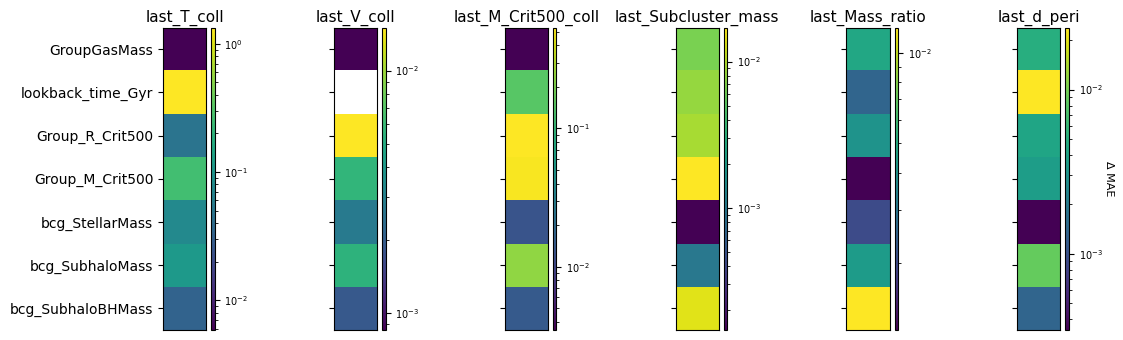

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1) Load the sensitivity matrix
sensitivity_df = pd.read_csv('processed_data/sensitivity_matrix_combined.csv', index_col=0)

# 2) Data & labels
heatmap_data   = sensitivity_df.values         # (n_targets, n_features)
target_labels  = sensitivity_df.index.tolist()
feature_labels = sensitivity_df.columns.tolist()

n_rows, n_cols = heatmap_data.shape

# 3) Create subplots: one column per feature
fig, axes = plt.subplots(
    1, n_cols,
    figsize=(n_cols * 2.0, n_rows * 0.5),
    squeeze=False
)

for j, ax in enumerate(axes[0]):
    col = heatmap_data[:, j][:, None]

    positive = col[col > 0]
    vmin = positive.min() if positive.size else 1e-3
    vmax = col.max()

    im = ax.imshow(
        col,
        aspect='equal',
        origin='lower',
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap='viridis'
    )

    ax.set_yticks(np.arange(n_rows))
    if j == 0:
        ax.set_yticklabels(target_labels, fontsize=10)
    else:
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_title(feature_labels[j], pad=4, fontsize=11)

    # add a colorbar to every panel
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=7)

    # only label the very last one
    if j == n_cols - 1:
        cbar.set_label('Δ MAE', rotation=270, labelpad=8, fontsize=8)
    else:
        cbar.set_label('')  # hide label on other bars

# tighten spacing
fig.subplots_adjust(wspace=0.15, hspace=0)
plt.tight_layout()
plt.savefig('3.sensitivity_analysis.png', dpi=300, bbox_inches='tight')
#plt.savefig('sensitivity_analysis.pdf', bbox_inches='tight')
plt.show()
